# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks'

In [2]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, 
                      draw_sample_xy, draw_sample_rphi, draw_sample_rz)

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['font.size'] = 14

## Load training results

Specify which results to load either by config file or training output directory.

In [5]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/heptrkx/results')

In [6]:
ls $result_base

RNNFilter_20180207_1121/  hpo_agnn_534171_3/   mpnn_hpo_526841_25/
agnn_000/                 hpo_agnn_534172_0/   mpnn_hpo_526841_26/
agnn_001/                 hpo_agnn_534172_1/   mpnn_hpo_526841_27/
agnn_002/                 hpo_agnn_534172_10/  mpnn_hpo_526841_28/
agnn_002_8gpu/            hpo_agnn_534172_11/  mpnn_hpo_526841_3/
agnn_003/                 hpo_agnn_534172_2/   mpnn_hpo_526841_4/
agnn_004/                 hpo_agnn_534172_3/   mpnn_hpo_526841_5/
agnn_005/                 hpo_agnn_534172_4/   mpnn_hpo_526841_6/
agnn_006/                 hpo_agnn_534172_5/   mpnn_hpo_526841_7/
agnn_007/                 hpo_agnn_534172_6/   mpnn_hpo_526841_8/
agnn_008/                 hpo_agnn_534172_7/   mpnn_hpo_526841_9/
agnn_009/                 hpo_agnn_534172_8/   mpnn_med_000/
agnn_010/                 hpo_agnn_534172_9/   mpnn_med_001/
agnn_big_000/             hpo_mpnn_534173_0/   mpnn_test/
agnn_big_001/             hpo_mpnn_534173_1/   nragnn_000/
agnn_big_002/             hpo_m

In [7]:
result_name = 'mpnn_010'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pprint.pprint(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 1,
          'input_dir': '${SCRATCH}/heptrkx/data/hitgraphs_high_000',
          'n_train': 32768,
          'n_valid': 4096,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 3},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_edge_layers': 4,
           'n_graph_iters': 8,
           'n_node_layers': 4,
           'name': 'mpnn'},
 'n_ranks': 8,
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 64,
                                      'factor': 0.1,
                                      'start_epoch': 32}],
               'name': 'Adam',
               'weight_decay': 1e-05},
 'output_dir': '/global/cscratch1/sd/sfarrell/heptrkx/results/mpnn_010',
 'trainer': {'name': 'gnn_sparse'},
 'training': {'n_total_epochs': 64}}

Training summaries:


,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.0010,0.299473,3659.108965,28.982348,0,385.898946,0.110814,0.953945,10.872655
1,0.0010,0.159548,3887.340402,30.774797,1,385.537334,0.089178,0.964779,9.444311
2,0.0010,0.124742,4086.778173,32.319119,2,383.553803,0.067126,0.974187,9.449974
3,0.0010,0.108353,4283.725735,33.854700,3,384.220478,0.064738,0.976054,8.264092
4,0.0010,0.098962,4500.644441,35.171343,4,383.885446,0.055352,0.980254,9.612513
...,...,...,...,...,...,...,...,...,...
59,0.0001,0.034694,4092.205668,34.507452,59,383.062704,0.019917,0.994592,8.273283
60,0.0001,0.034766,4077.830882,34.413268,60,382.794991,0.019601,0.994576,8.825280
61,0.0001,0.034646,4064.112152,34.316182,61,382.514602,0.019323,0.994834,8.622923
62,0.0001,0.035761,4067.674215,34.270110,62,383.396270,0.018923,0.994843,8.113838


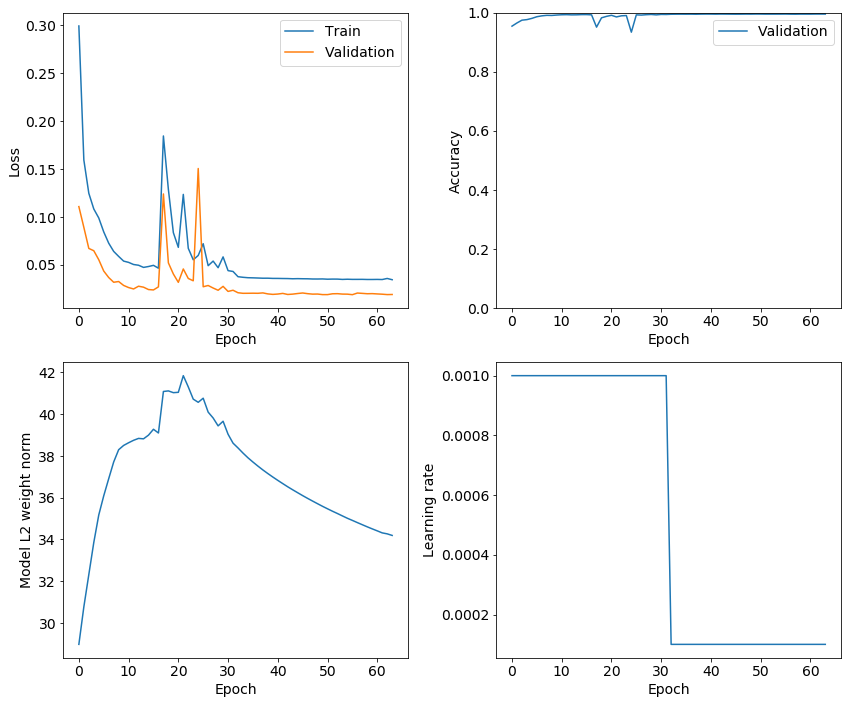

In [8]:
plot_train_history(summaries)

## Load the trained model

In [9]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
55,0.0001,0.034797,4152.824203,34.913331,55,383.206864,0.018825,0.994799,8.14648


In [10]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNN(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bia

## Load the test data set and evaluate the model

In [11]:
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [12]:
%%time
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 1min 49s, sys: 2.78 s, total: 1min 52s
Wall time: 29.3 s


In [13]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)
print('F1 score:  %.4f' % test_metrics.f1)

Test set results with threshold of 0.5
Accuracy:  0.9948
Precision: 0.9654
Recall:    0.9635
F1 score:  0.9644


In [14]:
threshold = 0.7
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)
print('F1 score:  %.4f' % test_metrics.f1)

Test set results with threshold of 0.7
Accuracy:  0.9954
Precision: 0.9818
Recall:    0.9545
F1 score:  0.9680


In [15]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)
print('F1 score:  %.4f' % test_metrics.f1)

Test set results with threshold of 0.8
Accuracy:  0.9953
Precision: 0.9887
Recall:    0.9472
F1 score:  0.9675


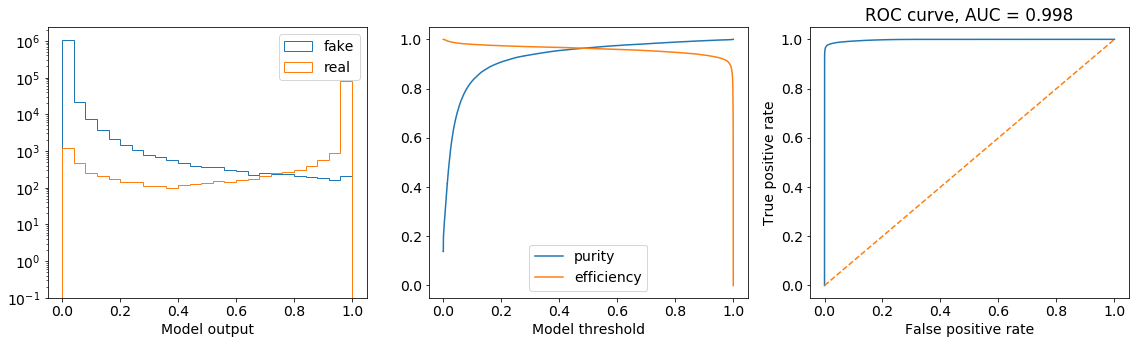

In [16]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [17]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [18]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

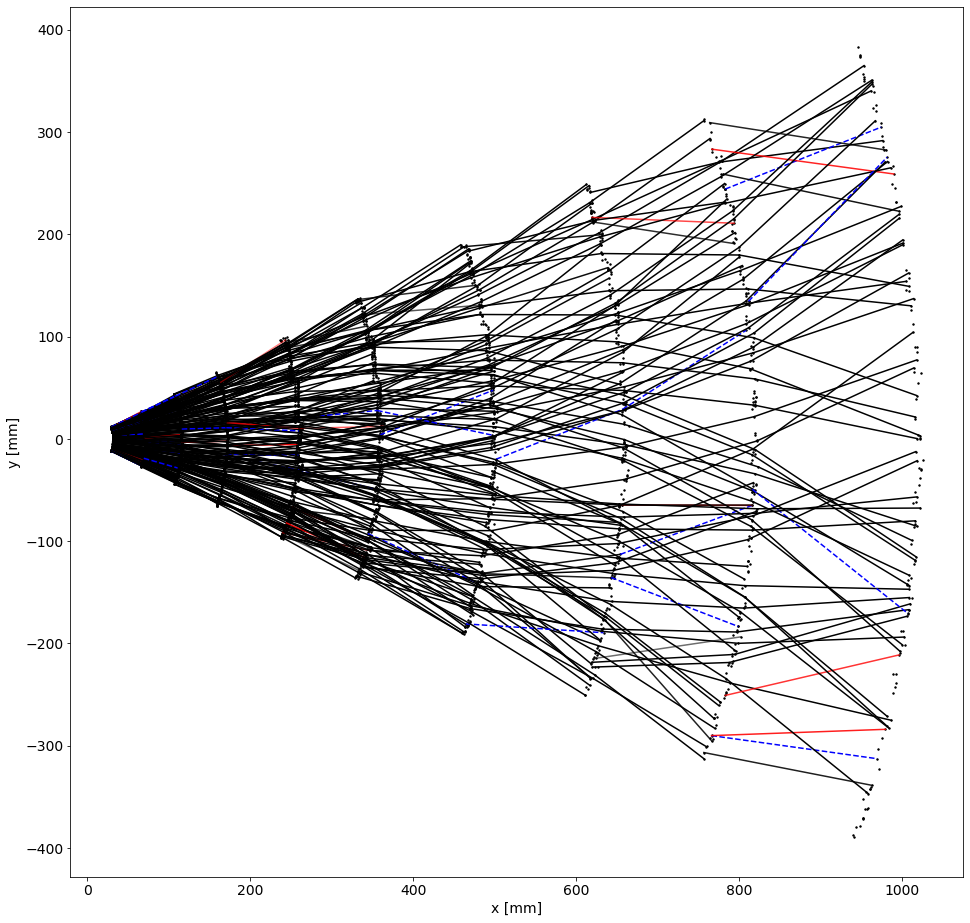

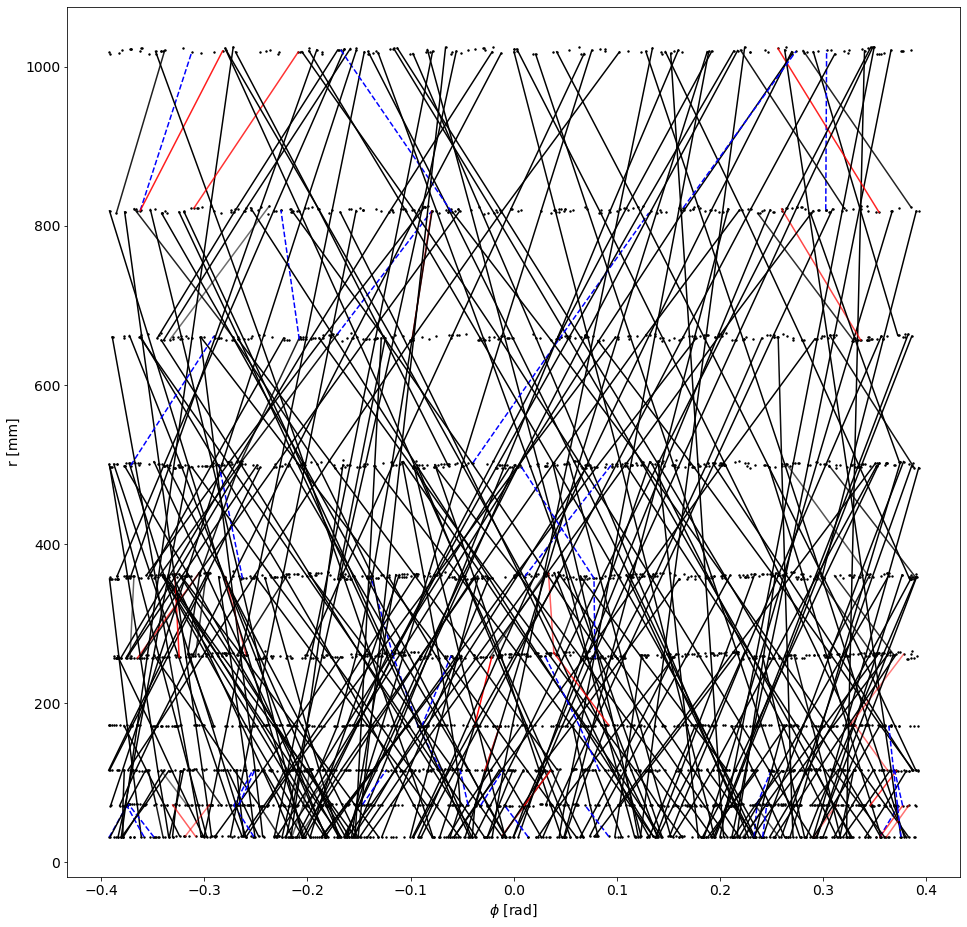

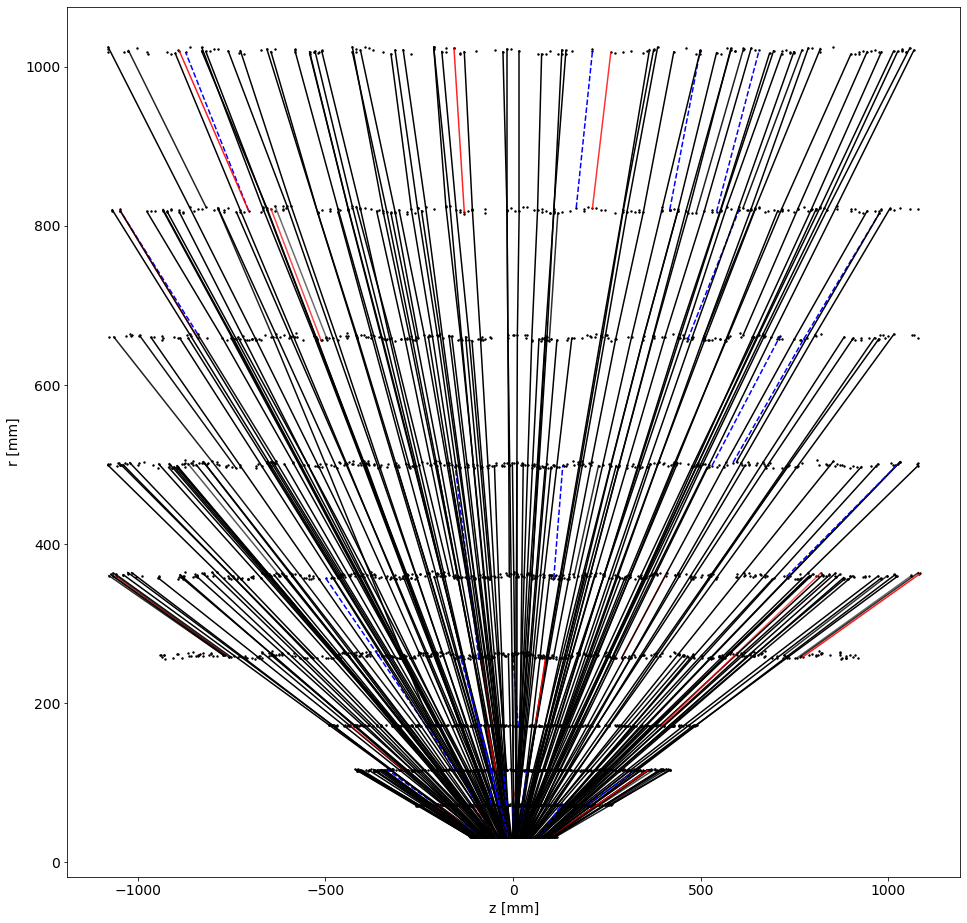

In [21]:
draw_cut = 0.5
draw_sample_xy(x, e, o, y, cut=draw_cut);
draw_sample_rphi(x, e, o, y, cut=draw_cut);
draw_sample_rz(x, e, o, y, cut=draw_cut);